# German Traffic Sign Recognition Benchmark (GTSRB) Classifier

We will use the [German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) dataset to train a classifier to recognize traffic signs. The dataset contains more than 50,000 images of 43 classes.

## Fast Gradient Sign Method (FGSM) Attack

We will try to implement FGSM and test it on our model

*Please make a copy of this notebook before you get started!!*

## Setup

In [1]:
# py(torch): our machine learning library!
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
# Pillow: Python Image Library
from PIL import Image
# pandas: data analysis library
import pandas as pd

import os

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")  # check if we are on CPU or GPU

### Load Training Data

In [5]:
TRAIN_PATH = "GTSRB/Final_Training/Images"

# normalize images in the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


### Load test data 

In [7]:
TEST_PATH = "GTSRB/Final_Test/Images/"
CSV_PATH = "GTSRB/Final_Test/Images/GT-final_test.csv"
class CustomTestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        # read csv file, seperator is ';'
        self.dataframe = pd.read_csv(csv_file, sep=';')
        # look at columns of dataframe
        print(self.dataframe.columns)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, -1])

        if self.transform:
            image = self.transform(image)

        return image, label

# normalize images in the dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = CustomTestDataset(csv_file=CSV_PATH, 
                                 img_dir=TEST_PATH, 
                                 transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Index(['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2',
       'ClassId'],
      dtype='object')


## Training and Testing

In [ ]:
def train(model, train_loader, criterion, optimizer, device, epochs=10, print_every=200):
    model.train()
    total_loss = 0.0
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs = data[0].to(device)
            labels = data[1].to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_loss += loss.item()
        if epoch % print_every == print_every - 1:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / print_every:.3f}")
            running_loss = 0.0
    return total_loss / len(train_loader)

In [ ]:
def evaluate(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)  # Move data to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


## Define Model Architecture

Skip to the next section if you want to use the pretrained model.

In [118]:
# We use a pretrained ResNet18 model and finetune it for our task
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)  # GTSRB has 43 classes so we need to change the last layer
model = model.to(device) # move model to GPU if available

d:\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training and Testing Loop

In [119]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, train_loader, criterion, optimizer, device, epochs=10, print_every=200)

In [24]:
evaluate(model, test_loader)

Accuracy: 98.82%


## Save model and weights

In [ ]:
# save the weights
torch.save(model.state_dict(), 'initial_model_weights.pth')

In [ ]:
# save the entire model
torch.save(model, 'initial_model.pth')

## Loading pretrained model

The pretrained model is a ResNet18 model with the last layer replaced with a linear layer with 43 outputs.
Its trained on the GTSRB dataset and achieves a validation accuracy of 98.5%

In [25]:
model = torch.load('initial_model.pth')

### Sanity check

We will do a sanity check to make sure the model is working as expected.
Feel free to skip this section if you want to get to the attack or if you are on a CPU.

In [ ]:
print(f'Accuracy: {100*(evaluate(model=model, test_loader=test_loader)):.2f}%')

## Visualizing our dataset

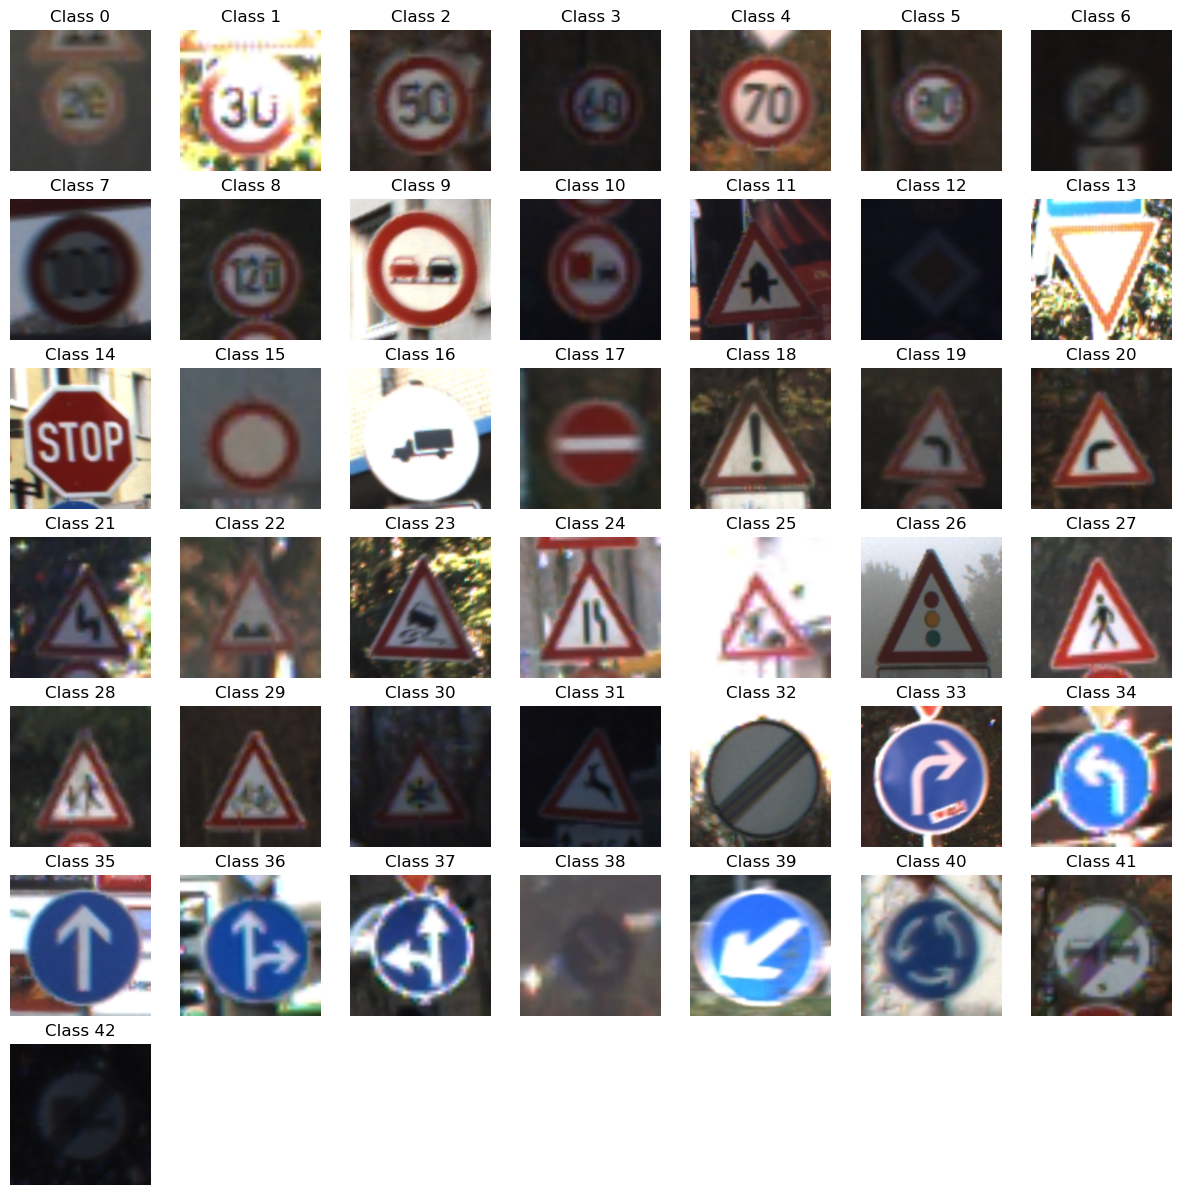

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a dictionary to hold one sample per class
class_samples = {}

# Function to unnormalize and convert tensor to numpy for plotting
def imshow(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # unnormalize
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)

    npimg = img_tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Collect one sample per class from the training set
for images, labels in train_loader:
    for i in range(len(labels)):
        label = labels[i].item()
        if label not in class_samples:
            class_samples[label] = images[i]
    if len(class_samples) == 43:  # Assuming there are 43 classes in GTSRB
        break

# sort the dictionary by keys
class_samples = dict(sorted(class_samples.items()))

# Plot one image from each class
fig = plt.figure(figsize=(15, 15))
for i, (label, img) in enumerate(class_samples.items()):
    ax = fig.add_subplot(7, 7, i + 1)  # Assuming a grid size that can fit all classes
    ax.set_title(f"Class {label}")
    ax.axis("off")

    # process the image and show it
    imshow(img)
plt.show()

# FGSM Attack!

Learn more about FGSM [here](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm#:~:text=The%20fast%20gradient%20sign%20method%20works%20by%20using%20the%20gradients,is%20called%20the%20adversarial%20image.).

In [8]:
import torch.nn.functional as F

def adversarial_attack(image, model, epsilon):
    pass
   

## Run fgsm attack on random image from test set

Ground truth class label: 12


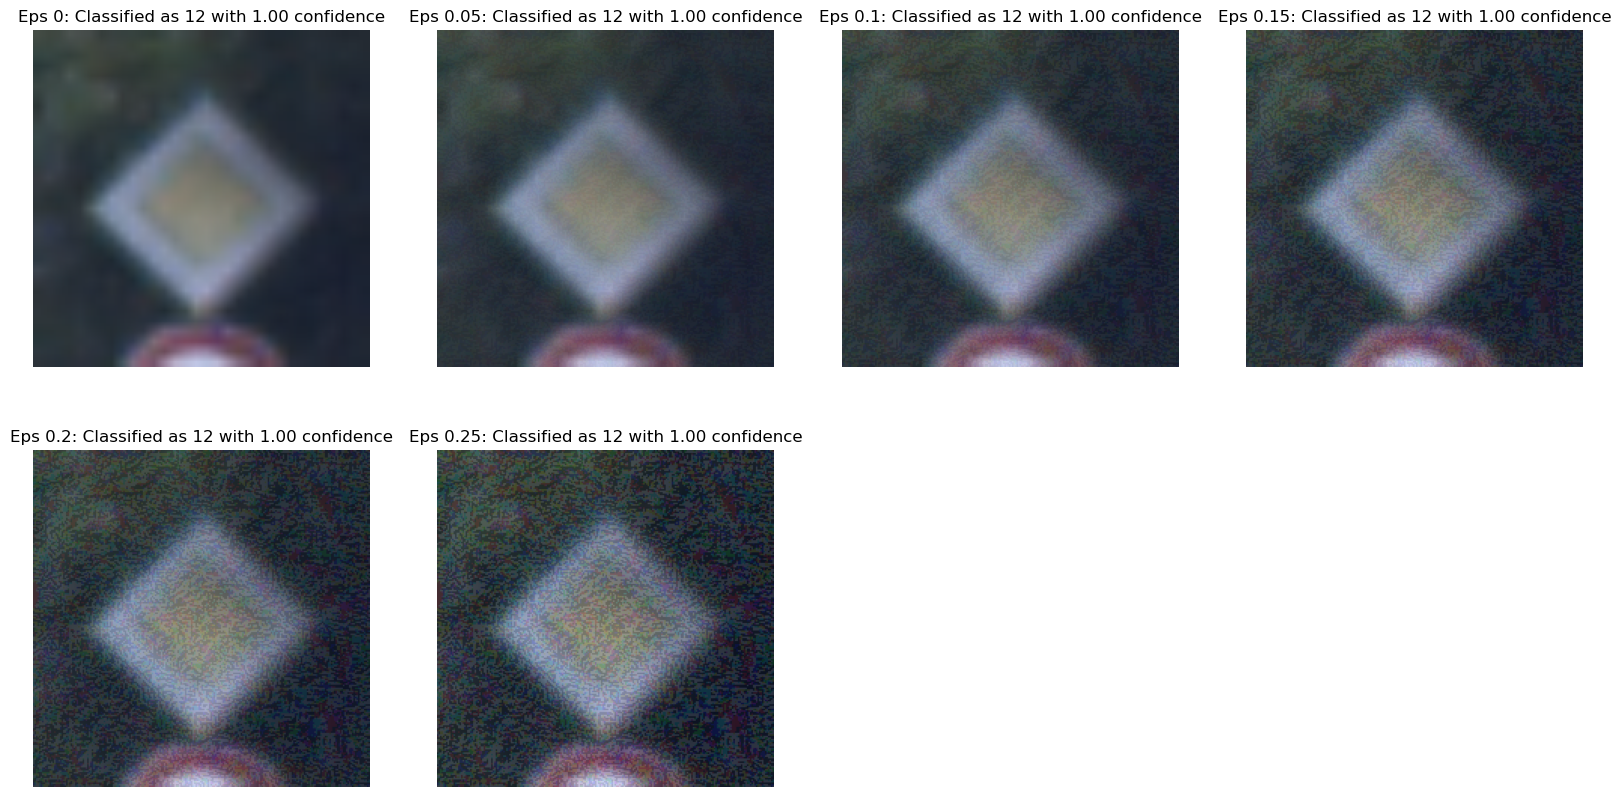

In [9]:
import random

model.eval()  # Set model to evaluation mode

# Load a random image from the test loader
test_iter = iter(test_loader)
images, labels = next(test_iter)
idx = random.randint(0, len(labels) - 1)
image, label = images[idx:idx+1], labels[idx:idx+1]
image, label = image.to(device), label.to(device)

# Print the ground truth label
print(f"Ground truth class label: {label.item()}")

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
ep_count = len(epsilons)

# Display original and perturbed images
PLOT_WIDTH = ep_count//2 + 1
PLOT_HEIGHT = 2

plt.figure(figsize=(PLOT_WIDTH*5, PLOT_HEIGHT*5))

# Run FGSM attack with different epsilon values
for i, eps in enumerate(epsilons):
    # Generate perturbed image
    perturbed_image = adversarial_attack(image, model, eps)
    # Classify the perturbed image
    perturbed_output = model(perturbed_image)
    _, perturbed_pred = perturbed_output.max(1)
    confidence = F.softmax(perturbed_output, dim=1)[0, perturbed_pred].item()


    # Convert tensors to NumPy arrays for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    perturbed_image = perturbed_image.detach()


    for t, m, s in zip( perturbed_image, mean, std):
        t.mul_(s).add_(m)

    perturbed_image = perturbed_image.squeeze().cpu().numpy()

    
    perturbed_image = perturbed_image.clip(0,1).transpose((1, 2, 0))

    plt.subplot(PLOT_HEIGHT, PLOT_WIDTH, i + 1)
    plt.title(f"Eps {eps}: Classified as {perturbed_pred.item()} with {confidence:.2f} confidence")
    plt.imshow(perturbed_image)
    plt.axis('off')

plt.show()


## Run fgsm attack on YOUR image!!!

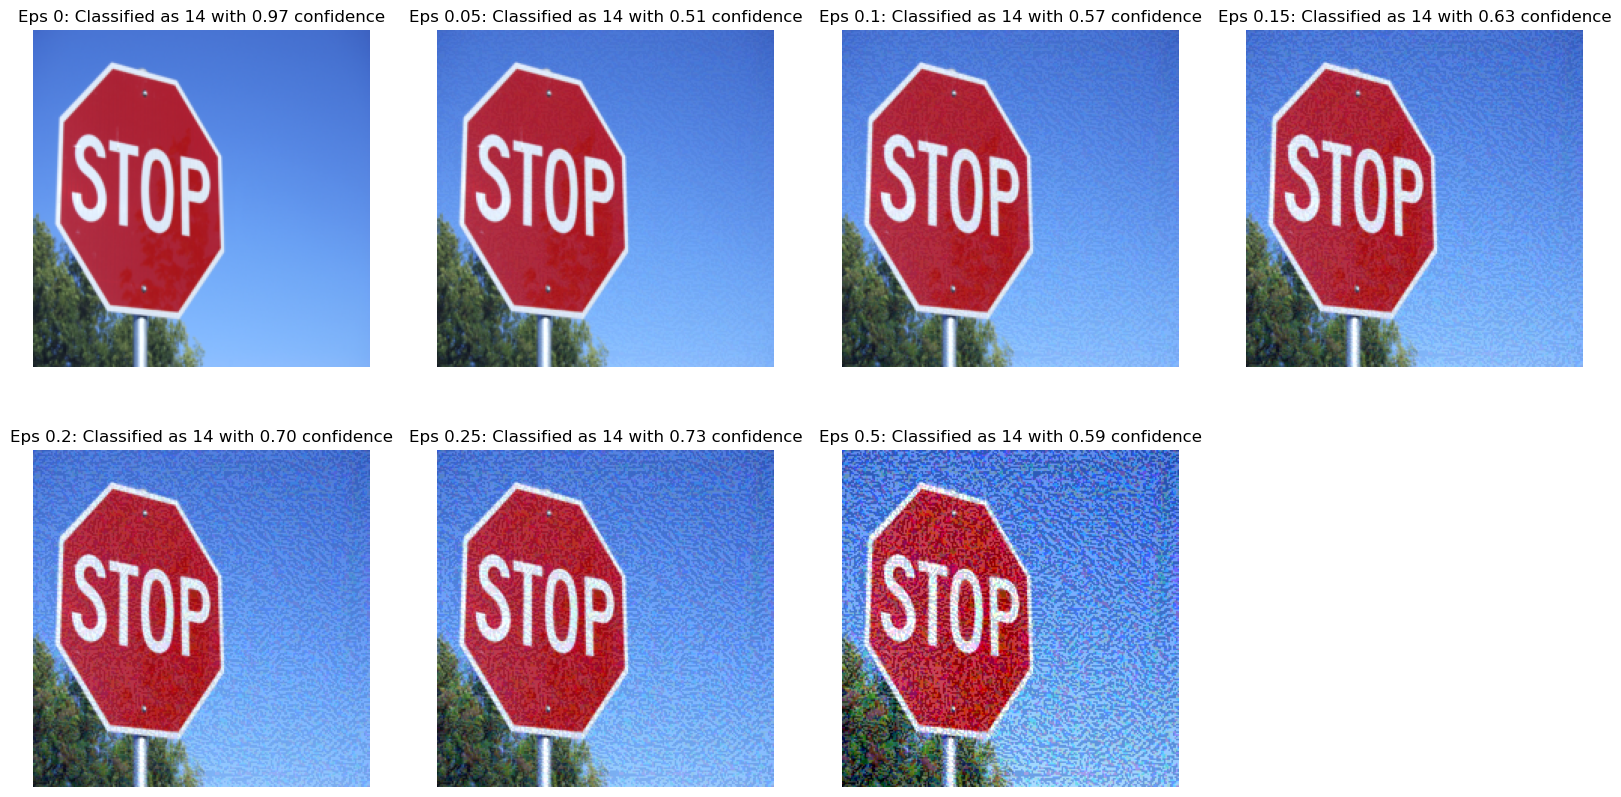

In [10]:
# Load and preprocess the image
image_path = "stop-sign1.jpg"  # Replace with the path to your image
input_image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model
image = input_batch.to(device)

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]
ep_count = len(epsilons)

# Display original and perturbed images
PLOT_WIDTH = ep_count//2 + 1
PLOT_HEIGHT = 2

plt.figure(figsize=(PLOT_WIDTH*5, PLOT_HEIGHT*5))

# Run FGSM attack with different epsilon values
for i, eps in enumerate(epsilons):
    # Generate perturbed image
    perturbed_image = fgsm_attack_with_preprocessing(image, model, eps)
    # Classify the perturbed image
    perturbed_output = model(perturbed_image)
    _, perturbed_pred = perturbed_output.max(1)
    confidence = F.softmax(perturbed_output, dim=1)[0, perturbed_pred].item()


    # Convert tensors to NumPy arrays for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    perturbed_image = perturbed_image.detach()


    for t, m, s in zip( perturbed_image, mean, std):
        t.mul_(s).add_(m)

    perturbed_image = perturbed_image.squeeze().cpu().numpy()

    
    perturbed_image = perturbed_image.clip(0,1).transpose((1, 2, 0))

    plt.subplot(PLOT_HEIGHT, PLOT_WIDTH, i + 1)
    plt.title(f"Eps {eps}: Classified as {perturbed_pred.item()} with {confidence:.2f} confidence")
    plt.imshow(perturbed_image)
    plt.axis('off')

plt.show()
